In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import itertools

# paths
train_path = 'BurImagesJPG_I/train/color'
valid_path = 'BurImagesJPG_I/validation/color'
test_path = 'BurImagesJPG_I/test/color'

# Load
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(250,200), classes=('damaged' , 'good'), batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(250,200), classes=('damaged' , 'good'), batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(250,200), classes=('damaged' , 'good'), batch_size=10)

Using TensorFlow backend.


Found 674 images belonging to 2 classes.
Found 136 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [6]:
def plots(ims, figsize=(25,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.array:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
imgs, labels = next(valid_batches)

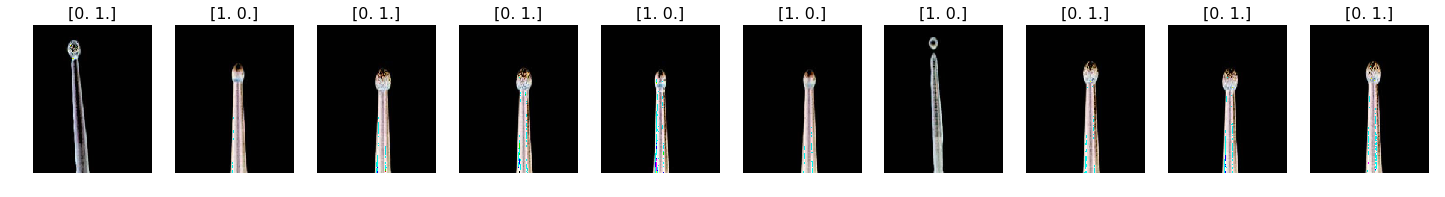

In [4]:
plots(imgs, titles=labels)

## Build and Train CNN

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(250,200,3)),
    Flatten(),
    Dense(2, activation='softmax'),
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 198, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1571328)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 3142658   
Total params: 3,143,554
Trainable params: 3,143,554
Non-trainable params: 0
_________________________________________________________________


In [5]:

model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(250,200,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 250, 200, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 100, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 100, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 50, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 62, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 50, 16)        12816     
__________

In [6]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.fit_generator(train_batches, steps_per_epoch=67, validation_data=valid_batches, validation_steps=4, epochs=3, verbose=2)

Epoch 1/3
 - 716s - loss: 8.6218 - acc: 0.4582 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/3
 - 799s - loss: 8.5895 - acc: 0.4574 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/3
 - 711s - loss: 8.5445 - acc: 0.4619 - val_loss: 8.8650 - val_acc: 0.4500


## Predict

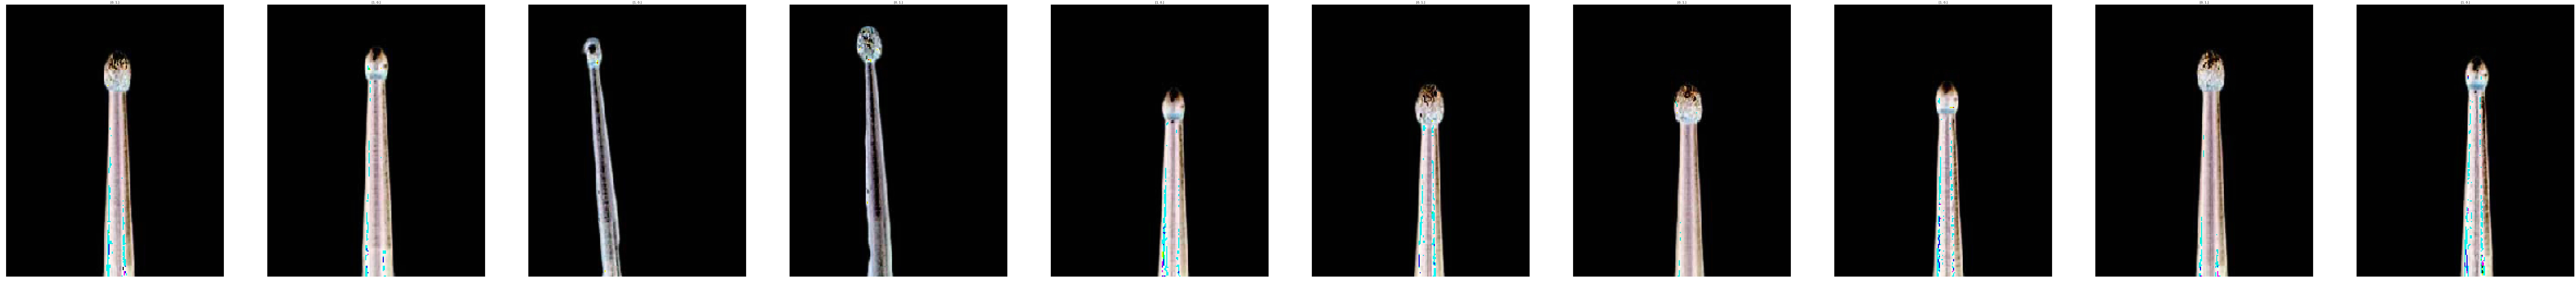

In [8]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [9]:
test_labels = test_labels[:,0]
test_labels

array([0., 1., 1., 0., 1., 0., 0., 1., 0., 1.], dtype=float32)

In [10]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [13]:
predictions = model.predict(test_imgs, verbose=0)

In [11]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [12]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color='white' if cm[i ,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

Confusion matrix, without normalization
[[0 5]
 [0 5]]


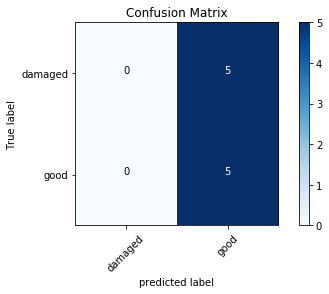

In [14]:
cm_plot_labels = ['damaged', 'good']
plot_confusion_matrix(cm, cm_plot_labels, title= 'Confusion Matrix')

In [16]:
score = model.evaluate_generator(train_batches)
print("accuracy: ", score[1])

('accuracy: ', 0.4569733026119651)
